<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/reg_ativa_exemplos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplos e simulações iniciais para nosso metodo de regressão ativa

In [ ]:
# pacotes
# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

# montando o colab
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/Colab Notebooks/active_learning/figuras'

Mounted at /content/gdrive


# Simulações iniciais

Simulando dados de uma regressão linear apenas para testar se funciona a implementação do método pelo modAL:

In [ ]:
# gerando os X's
np.random.seed(1500)
n = 1200
X = np.random.uniform(low=0, high = 4, size = n)

# gerando os y por uma regressao linear
beta_0 = 1
beta_1 = 0.75
y = beta_0 + beta_1 * X + np.random.normal(loc = 0, scale = 0.25, size = n)


sim_data_lin = pd.DataFrame(data = {'X' : X,
                                'Y' : y})

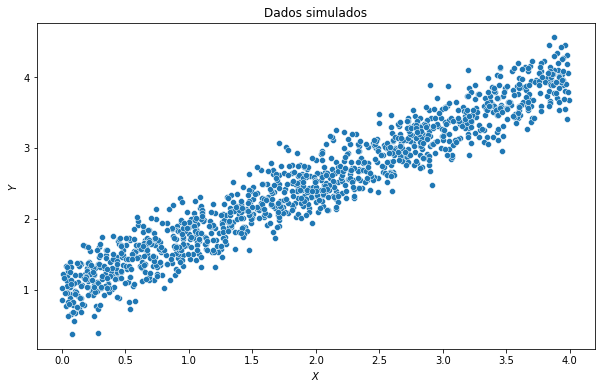

In [ ]:
plt.figure(figsize = (10,6))
sns.scatterplot(data = sim_data_lin, x = "X", y = "Y", color = "tab:blue")
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados simulados")
plt.savefig(f"{images_dir}/reg_lin_sim_data.pdf")
plt.show()

Dividindo em treino e teste e pegando apenas 5 pontos iniciais para treinamento:

In [ ]:
from sklearn.model_selection import train_test_split
# teste para ver desempenho depois
X_pool_lin, X_test_lin, y_pool_lin, y_test_lin = train_test_split(X.reshape(-1, 1), y, test_size = 0.2, random_state=42)

# setando as amostras iniciais:
np.random.seed(2018)
# 20 de treinamento inicial
n_initial = 10
train_idx = np.random.choice(range(X_pool_lin.shape[0]), size = n_initial, replace = False)
X_train_lin = X_pool_lin[train_idx]
y_train_lin = y_pool_lin[train_idx]

# reduzindo a pool
X_pool_lin = np.delete(X_pool_lin, train_idx, axis=0)
y_pool_lin = np.delete(y_pool_lin, train_idx)

Criando a estrategia de consulta por hora com um 2-fold:

In [ ]:
from sklearn.model_selection import KFold
!pip install modAL
from modAL import ActiveLearner
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor

# Y = 30 X1 + 10 X2 + 0.05 X3
# colocar depois outro nome
def bias_reduction(regressor, X, valid_regressor = KNeighborsRegressor(), k = 2, random_state = 99):
  # splitting into two folds:
  kf = KFold(n_splits = k, random_state = random_state, shuffle = True)
  # obtaining labeled data by regressor
  X_labeled, y_labeled = regressor.X_training, regressor.y_training

  errors = np.zeros((X.shape[0], k))
  # K-fold loop
  i = 0
  for train_idx, test_idx in kf.split(X_labeled):
    X_train, X_test = X_labeled[train_idx], X_labeled[test_idx]
    y_train, y_test = y_labeled[train_idx], y_labeled[test_idx]
    # first, fitting the current training data
    # cloning regressor
    train_learner = clone(regressor.estimator)
    train_learner.fit(X = X_train, y = y_train)

    # now obtaining Z
    z = (y_test - train_learner.predict(X_test))**2

    # fitting the regression on z
    valid_learner = clone(valid_regressor)
    valid_learner.fit(X = X_test, y = z)

    # now obtaining the errors for each observation in the pool
    errors[:, i] = valid_learner.predict(X)
    i += 1
  
  # obtaining scores by computing the row-wise means of errors
  scores = errors.mean(axis=1)

  # sorting index in descending order
  ranked = np.argsort(scores)
  query_idx = ranked[::-1][0]

  # finally returning the index
  return query_idx, X[query_idx]


# definindo uma estrategia aleatoria
def random_sampling(regressor, X_pool):
  n_samples = len(X_pool)
  query_idx = np.random.choice(range(n_samples))
  return query_idx, X_pool[query_idx]

# laco da modelagem
def laco_modelo(n_queries, modelo, X_pool, y_pool, X_test, y_test, 
                trace = False, col = None, s = None, index = None, **fit_kwargs):
  list_mse = [mean_squared_error(y_test, modelo.predict(X_test))]
  X_pool_c, y_pool_c = np.copy(X_pool), np.copy(y_pool)

  # lasso do aprendizado ativo:
  for i in range(n_queries):
    query_idx, query_instance = modelo.query(X_pool_c, **fit_kwargs)
    X_sel, y_sel = X_pool_c[query_idx].reshape(1, -1), y_pool_c[query_idx].reshape(1, )
    modelo.teach(X = X_sel, y = y_sel)
    X_pool_c, y_pool_c = np.delete(X_pool_c, query_idx, axis=0), np.delete(y_pool_c, query_idx)
    if (trace):
      col[index[query_idx]] = 'green'
      s[index[query_idx]] = 50
      index = np.delete(index, query_idx)
    list_mse.append(mean_squared_error(y_test, modelo.predict(X_test)))
  if (trace):
    return [list_mse, col, s]
  return list_mse

In [ ]:
# funcao para preparar amostra de treino inicial a partir da pool
# argumento "colorize" e para se queremos colorir e retornar cores

def prepare_train(X_pool, y_pool, n_initial = 10, colorize = False, seed = 700):
  np.random.seed(seed)
  # amostrando aleatoriamente sem reposicao
  train_idx = np.random.choice(range(X_pool.shape[0]),
    size = n_initial, replace = False)
  X_train = X_pool[train_idx]
  y_train = y_pool[train_idx]
  dict_al = {}
  if colorize:
    s = []
    col = []
    index = np.arange(0, X_pool.shape[0])
    for i in range(0, X_pool.shape[0]):
      if i in train_idx:
        col.append('red')
        s.append(50)
      else:
        col.append('black')
        s.append(20)
    index = np.delete(index, train_idx)
    dict_al = {"size" : s, "color" : col,"index" : index}

  # reduzindo a pool
  X_pool = np.delete(X_pool, train_idx, axis=0)
  y_pool = np.delete(y_pool, train_idx)
  dict_al["X_pool"], dict_al["y_pool"] = X_pool, y_pool
  dict_al["X_train"], dict_al["y_train"] = X_train, y_train
  return(dict_al)

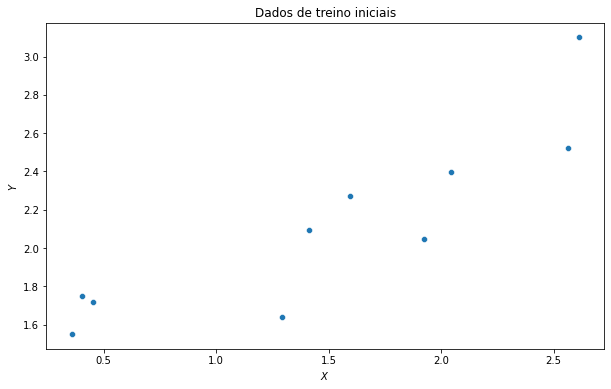

In [ ]:
sns.set_palette("Set1")
plt.figure(figsize = (10,6))
sns.scatterplot(x = X_train_lin.ravel(), y = y_train_lin, color = "tab:blue")
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados de treino iniciais")
plt.savefig(f"{images_dir}/reg_lin_train_sim_data.pdf")

Testando por hora no exemplo simples essa estratégia e vendo se funciona

In [ ]:
# initializing learners
from sklearn.linear_model import LinearRegression

reg_mod = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = bias_reduction,
                     X_training = X_train_lin, y_training = y_train_lin)

reg_mod_random = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = random_sampling,
                     X_training = X_train_lin, y_training = y_train_lin)

Analisando o comportamento dessa estratégia e comparando depois com a amostragem aleatória:

In [ ]:
from sklearn.metrics import mean_squared_error
n_queries = 30
np.random.seed(1500)
list_mse_br = laco_modelo(n_queries, reg_mod, 
                          X_pool_lin, y_pool_lin, X_test_lin, y_test_lin, 
                          valid_regressor = KNeighborsRegressor())

list_mse_rand = laco_modelo(n_queries, reg_mod_random, 
                            X_pool_lin, y_pool_lin, X_test_lin, y_test_lin)

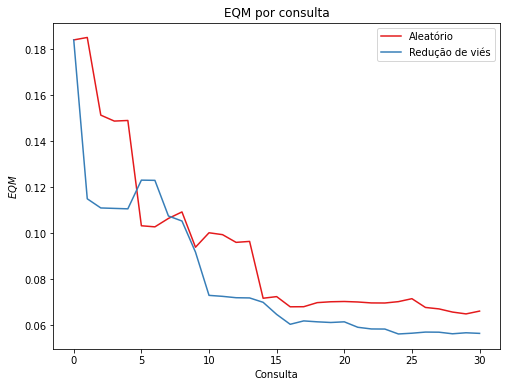

In [ ]:
queries = np.arange(0, n_queries + 1)
plt.figure(figsize = (8, 6))
plt.plot(queries, np.array(list_mse_rand), label = "Aleatório")
plt.plot(queries, np.array(list_mse_br), label = "Redução de viés")
plt.xlabel(r"Consulta")
plt.ylabel(r"$EQM$")
plt.title("EQM por consulta")
plt.legend()
plt.savefig(f"{images_dir}/eqm_por_consulta_reg_lin.pdf")
plt.show()

Experimento proposto pelo professor:

In [ ]:
# gerando de uma regressao nao linear
np.random.seed(700)
n = 200
X = np.random.uniform(low=0, high = 4, size = n)

# gerando os y por uma regressao linear
beta_0 = 1
beta_1 = 0.75
y = beta_0 + beta_1 * X + 2*(np.sin(X)**2) + np.random.normal(loc = 0, scale = 0.15, size = n)


# teste para ver desempenho depois
X_pool_ex2, X_test_ex2, y_pool_ex2, y_test_ex2 = train_test_split(X.reshape(-1, 1), y, test_size = 0.3, random_state=42)

sim_data = pd.DataFrame(data = {'X' : X_pool_ex2.ravel(),
                                'Y' : y_pool_ex2})

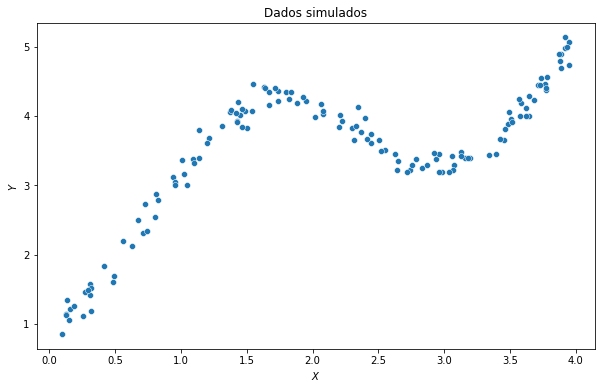

In [ ]:
plt.figure(figsize = (10,6))
sns.scatterplot(data = sim_data, x = "X", y = "Y", color = "tab:blue")
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados simulados")
plt.show()

In [ ]:
# amostrando aleatoriamente sem reposicao
n_initial = 10
train_idx = np.random.choice(range(X_pool_ex2.shape[0]),
    size = n_initial, replace = False)

s = []
col = []
index = np.arange(0, X_pool_ex2.shape[0])

for i in range(0, X_pool_ex2.shape[0]):
  if i in train_idx:
    col.append('red')
    s.append(50)
  else:
    col.append('black')
    s.append(20)

col_br, col_rand = col.copy(), col.copy()
s_br, s_rand = s.copy(), s.copy()

index = np.delete(index, train_idx)

X_train_ex2 = X_pool_ex2[train_idx]
y_train_ex2 = y_pool_ex2[train_idx]

# reduzindo a pool
X_pool_ex2 = np.delete(X_pool_ex2, train_idx, axis=0)
y_pool_ex2 = np.delete(y_pool_ex2, train_idx)

In [ ]:
# iniciando os modelos
reg_mod = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = bias_reduction,
                     X_training = X_train_ex2, y_training = y_train_ex2)

reg_mod_random = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = random_sampling,
                     X_training = X_train_ex2, y_training = y_train_ex2)

In [ ]:
from sklearn.metrics import mean_squared_error
n_queries = 20
list_br = laco_modelo(n_queries, reg_mod, 
                          X_pool_ex2, y_pool_ex2, X_test_ex2, y_test_ex2,
                          trace = True, col = col_br, s = s_br, index = index)
list_rand = laco_modelo(n_queries, reg_mod_random, X_pool_ex2, 
                        y_pool_ex2, X_test_ex2, y_test_ex2, trace = True, 
                        col = col_rand, s = s_rand, index = index)

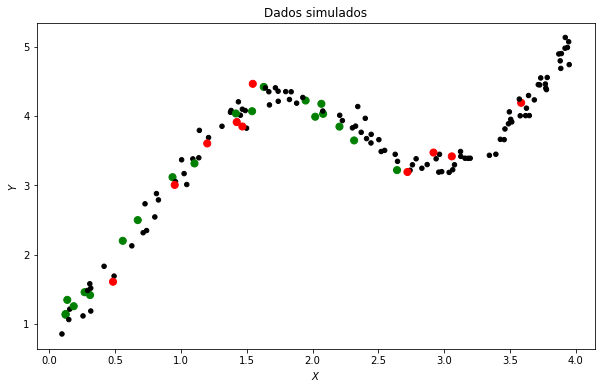

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x = sim_data.iloc[:,0].values, y = sim_data.iloc[:,1].values, 
                color = list_br[1], s = list_br[2])
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados simulados")
plt.show()

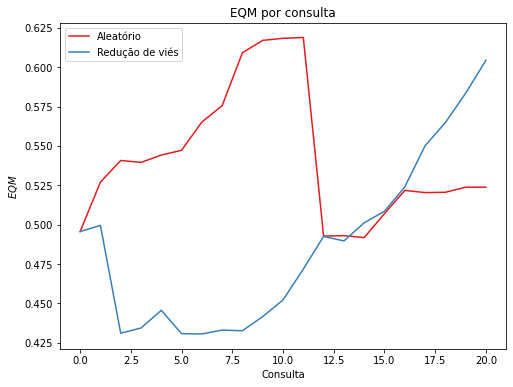

In [ ]:
queries = np.arange(0, 21)
plt.figure(figsize = (8, 6))
plt.plot(queries, np.array(list_rand[0]), label = "Aleatório")
plt.plot(queries, np.array(list_br[0]), label = "Redução de viés")
plt.xlabel(r"Consulta")
plt.ylabel(r"$EQM$")
plt.title("EQM por consulta")
plt.legend()
plt.savefig(f"{images_dir}/eqm_por_consulta_reg_nao_lin.pdf")
plt.show()

# Testando diferentes combinações de modelos

Testando as diferentes combinações dois a dois sugeridas pelo professor:


*   Modelo de treino: RL, KNN, RF
*   Modelo de validação: RL, KNN, RF



In [ ]:
# importando os modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# fazendo todas as combinacoes 2 a 2
# array de modelos
mods = np.array([LinearRegression(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor()])
string_mods = np.array(["LR", "RFR", "KNR"])
mesh = np.array(np.meshgrid(mods, mods)).T.reshape(-1, 2)

In [ ]:
# funcao que retonar um dicionario com as listas de AL de cada combinacao
def mse_comb(n_queries, X_train, y_train, X_pool, y_pool,
             X_test, y_test, mods_list, seed = 99):
  np.random.seed(seed)
  comb_grid = np.array(np.meshgrid(mods_list, mods_list)).T.reshape(-1, 2)
  dici_mse = dict()
  model_list = []

  for comb in comb_grid:
    reg_mod = ActiveLearner(estimator = comb[0],
                     query_strategy = bias_reduction,
                     X_training = X_train, y_training = y_train)
    
    list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test, 
                          valid_regressor = comb[1])
    # string da combinacao
    str1 = ''.join([c for c in str(comb[0]) if c.isupper()])
    str2 = ''.join([c for c in str(comb[1]) if c.isupper()])

    if comb[0] not in model_list:
      reg_mod_random = ActiveLearner(estimator = comb[0],
                     query_strategy = random_sampling,
                     X_training = X_train, y_training = y_train)
      
      list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
      
      model_list.append(comb[0])
      dici_mse[str1 + " " + "Random"] = list_rand
      
    dici_mse[str1 + " " + str2] = list_mse

    
    if comb[0] not in model_list:
      reg_mod_random = ActiveLearner(estimator = comb[0],
                     query_strategy = random_sampling,
                     X_training = X_train, y_training = y_train)
      
      list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
      
      model_list.append(comb[0])
      dici_mse[str1 + " " + "Random"] = list_rand

  return(dici_mse)

## BD simulado linear

In [ ]:
n = 30
dici_lin = mse_comb(n_queries = n, X_train = X_train_lin, y_train = y_train_lin, 
                    X_pool = X_pool_lin, y_pool = y_pool_lin, X_test = X_test_lin, y_test = y_test_lin, 
                    mods_list = mods, seed = 1750)

Montando os dados para fazer graficos 3 x 3 comparando o desempenho com a amostragem aleatória:

In [ ]:
def create_sim_data(dici_mods):
  create = True
  for key in dici_mods.keys():
    mod_string = key.split(" ")
    if mod_string[1] == 'Random':
      if create:
        df_final = pd.DataFrame({"score" : np.tile(dici_mods[key], 3),
                      "consulta" : np.tile(np.arange(0, len(dici_mods[key])), 3),
                      "ajuste" : np.tile(mod_string[0], 3*len(dici_mods[key])),
                      "metodo": np.tile("Random", 3*len(dici_mods[key]))}
                    )
        create = False
      else:
        df_temp = pd.DataFrame({"score" : np.tile(dici_mods[key], 3),
                      "consulta" : np.tile(np.arange(0, len(dici_mods[key])), 3),
                      "ajuste" : np.tile(mod_string[0], 3*len(dici_mods[key])),
                      "metodo": np.tile("Random", 3*len(dici_mods[key]))}
                    )
        df_final = df_final.append(df_temp, ignore_index = True)
    else:
      df_temp = pd.DataFrame({"score" : dici_mods[key],
                             "consulta" : np.arange(0, len(dici_mods[key])),
                             "ajuste" : mod_string[0],
                              "metodo": np.tile("Redução de viés" + " (" + mod_string[1] + ")", len(dici_mods[key]))}
                             )
      df_final = df_final.append(df_temp, ignore_index = True)
  df_final = df_final.replace({"KNR": "KNN", "RFR": "RF"}, regex = True)
  return df_final

In [ ]:
sim_lin = create_sim_data(dici_lin)

In [ ]:
sim_lin

,score,consulta,ajuste,metodo
0,0.184084,0,LR,Random
1,0.124557,1,LR,Random
2,0.118971,2,LR,Random
3,0.126374,3,LR,Random
4,0.127301,4,LR,Random
...,...,...,...,...
553,0.084969,26,KNN,Redução de viés (KNN)
554,0.084892,27,KNN,Redução de viés (KNN)
555,0.083654,28,KNN,Redução de viés (KNN)
556,0.080942,29,KNN,Redução de viés (KNN)


Plotando

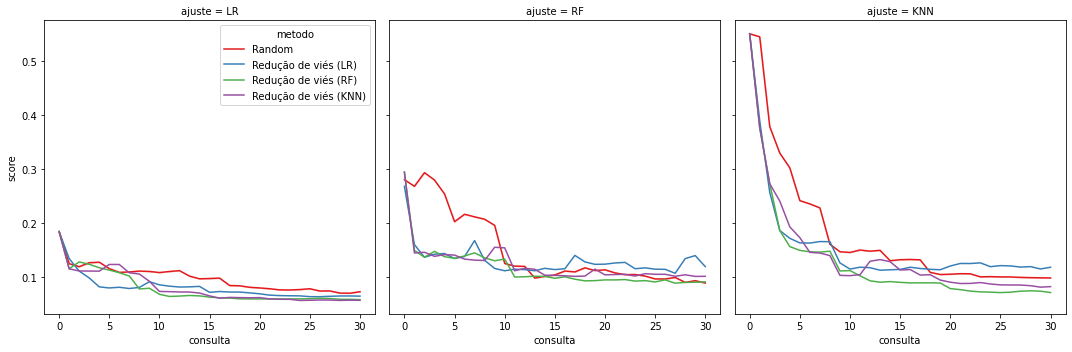

In [ ]:
g = sns.FacetGrid(sim_lin, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend(loc = "upper right")
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_1_all_comb.pdf")
plt.show()

## BD simulado não linear

In [ ]:
n = 30
dici_ex2 = mse_comb(n_queries = n, X_train = X_train_ex2, y_train = y_train_ex2, 
                    X_pool = X_pool_ex2, y_pool = y_pool_ex2, X_test = X_test_ex2, y_test = y_test_ex2, 
                    mods_list = mods, seed = 2150)

In [ ]:
sim_ex2 = create_sim_data(dici_ex2)

In [ ]:
sim_ex2

,score,consulta,ajuste,metodo
0,0.495638,0,LR,Random
1,0.495647,1,LR,Random
2,0.498132,2,LR,Random
3,0.536138,3,LR,Random
4,0.567279,4,LR,Random
...,...,...,...,...
553,0.042732,26,KNN,Redução de viés (KNN)
554,0.030904,27,KNN,Redução de viés (KNN)
555,0.030755,28,KNN,Redução de viés (KNN)
556,0.031817,29,KNN,Redução de viés (KNN)


<Figure size 864x576 with 0 Axes>

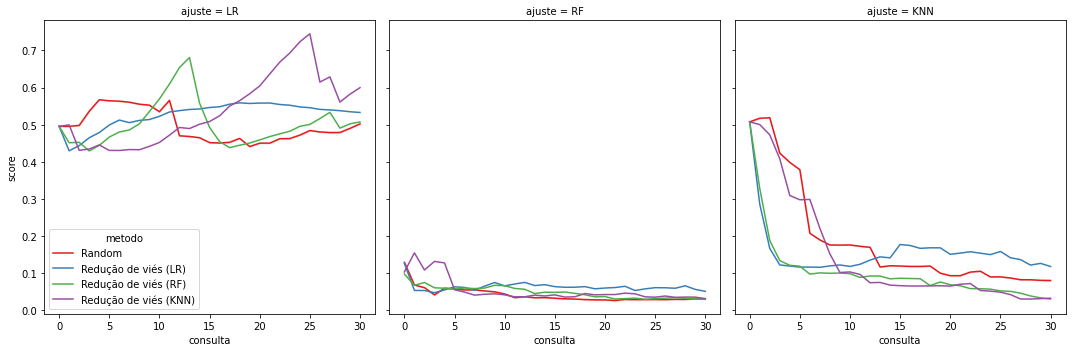

In [ ]:
plt.figure(figsize = (12, 8))
g = sns.FacetGrid(sim_ex2, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend()
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_2_all_comb.pdf")
plt.show()

## BD simulado não linear heterocedastico

In [ ]:
# gerando de uma regressao nao linear
np.random.seed(1200)
n = 200
X = np.random.uniform(low=0, high = 4, size = n)

# gerando os y por uma regressao linear
beta_0 = 1
beta_1 = 0.75
y = beta_0 + beta_1 * X + 2*(np.sin(X)**2) + np.random.normal(loc = 0, scale = np.round(X, decimals = 1)/4, size = n)

# teste para ver desempenho depois
X_pool_ex3, X_test_ex3, y_pool_ex3, y_test_ex3 = train_test_split(X.reshape(-1, 1), y, test_size = 0.3, random_state=42)

ex3_data = pd.DataFrame(data = {'X' : X_pool_ex3.ravel(),
                                'Y' : y_pool_ex3})

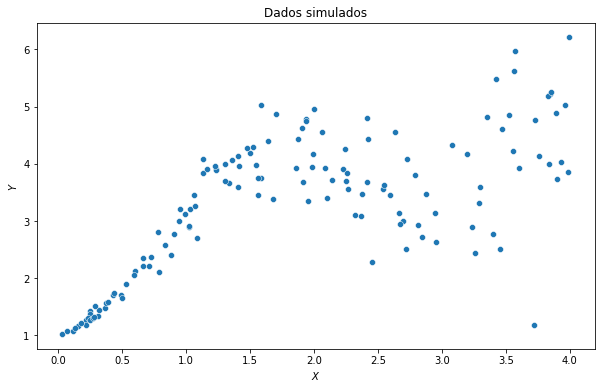

In [ ]:
plt.figure(figsize = (10,6))
sns.scatterplot(data = ex3_data, x = "X", y = "Y", color = "tab:blue")
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados simulados")
plt.show()

In [ ]:
dict_ex3 = prepare_train(X_pool_ex3, y_pool_ex3, seed = 850)

In [ ]:
n = 30
dici_ex3 = mse_comb(n_queries = n, X_train = dict_ex3["X_train"], y_train = dict_ex3["y_train"], 
                    X_pool = dict_ex3["X_pool"], y_pool = dict_ex3["y_pool"], X_test = X_test_ex3, y_test = y_test_ex3, 
                    mods_list = mods, seed = 2750)

In [ ]:
sim_ex3 = create_sim_data(dici_ex3)

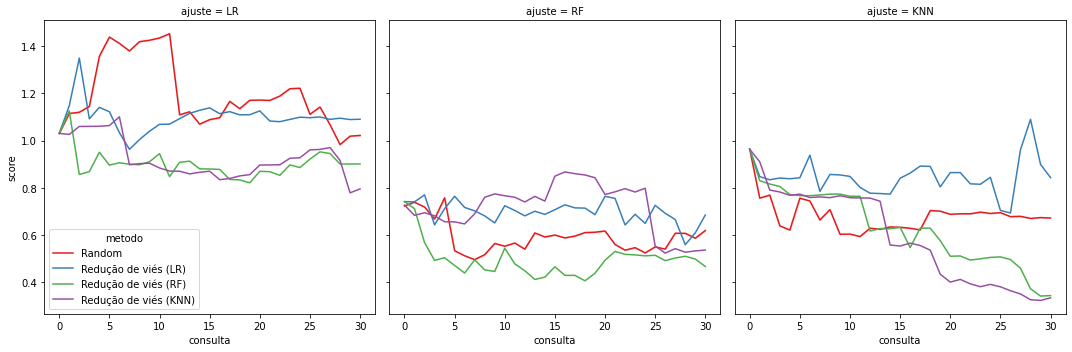

In [ ]:
g = sns.FacetGrid(sim_ex3, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend()
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_3_all_comb.pdf")
plt.show()

Como temos muitas flutações é interessante fazer a média de varias sementes

In [ ]:
n = 30
seed_master = 1500
nrand = 100
np.random.seed(seed_master)
seeds = np.random.choice(np.arange(0, 5500), size = nrand)
sim_data = []

for i in range(nrand):
  dici = mse_comb(n_queries = n, X_train = dict_ex3["X_train"], y_train = dict_ex3["y_train"], 
                    X_pool = dict_ex3["X_pool"], y_pool = dict_ex3["y_pool"], X_test = X_test_ex3, y_test = y_test_ex3, 
                    mods_list = mods, seed = seeds[i])
  temp_data = create_sim_data(dici)
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  sim_data.append(temp_data)

df = pd.concat(sim_data, axis=0, ignore_index=True)

In [ ]:
df_ex4 = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})

In [ ]:
df_ex4

,ID,score,consulta,ajuste,metodo
0,0,1.030341,0,LR,Random
1,1,1.026653,1,LR,Random
2,2,1.028279,2,LR,Random
3,3,1.027575,3,LR,Random
4,4,1.024719,4,LR,Random
...,...,...,...,...,...
553,553,0.365137,26,KNN,Redução de viés (KNN)
554,554,0.351398,27,KNN,Redução de viés (KNN)
555,555,0.327059,28,KNN,Redução de viés (KNN)
556,556,0.323909,29,KNN,Redução de viés (KNN)


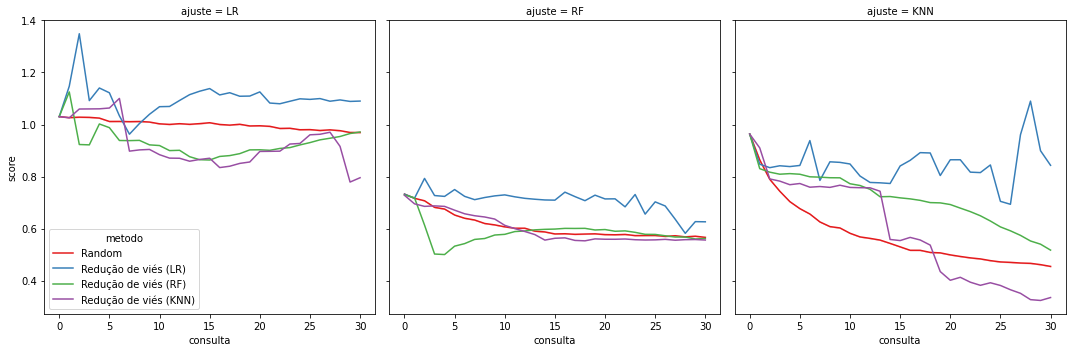

In [ ]:
g = sns.FacetGrid(df_ex4, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend()
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_4_all_comb.pdf")
plt.show()